In [2]:
import sys
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

In [3]:
# --- Load VoD dataset sample ---
repo_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from common_src.dataset.view_of_delft import ViewOfDelft
from vod.frame import FrameDataLoader, FrameTransformMatrix, homogeneous_transformation
from vod.configuration import KittiLocations

dataset = ViewOfDelft(data_root=os.path.join(repo_root, 'data/view_of_delft'), split='train')
sample = dataset[0]
lidar = sample['lidar_data'].numpy()  # (N, 4)
meta = sample['meta']
frame_id = meta['num_frame']

In [4]:
# --- Load RGB + calibration ---
vod = FrameDataLoader(KittiLocations(os.path.join(repo_root, 'data/view_of_delft')), frame_number=frame_id)
transforms = FrameTransformMatrix(vod)
rgb = vod.image  # (H, W, 3)
H, W, _ = rgb.shape

In [5]:
# --- Prepare MobileNetV3 model ---
model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [6]:
# --- Prepare image for MobileNet (no resize) ---
img_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])(Image.fromarray(rgb)).unsqueeze(0)

In [7]:
# --- Run segmentation ---
with torch.no_grad():
    output = model(img_tensor)['out'][0]  # [21, H, W]

output_permute = output.permute(1, 2, 0)  # [H, W, 21]
output_probability, output_predictions = output_permute.max(2)

In [8]:
# --- Reassign to 4 classes ---
detect_object_mask = (output_predictions == 0) | (output_predictions == 2) | (output_predictions == 7) | (output_predictions == 15)
other_object_mask = ~detect_object_mask

output_reassign = torch.zeros(output_permute.shape[0], output_permute.shape[1], 4)
output_reassign[:, :, 0] = detect_object_mask * output_permute[:, :, 0] + other_object_mask * output_probability  # background
output_reassign[:, :, 1] = output_permute[:, :, 2]   # bicycle
output_reassign[:, :, 2] = output_permute[:, :, 7]   # car
output_reassign[:, :, 3] = output_permute[:, :, 15]  # person

output_reassign_softmax = F.softmax(output_reassign, dim=2).cpu().numpy()  # [H, W, 4]

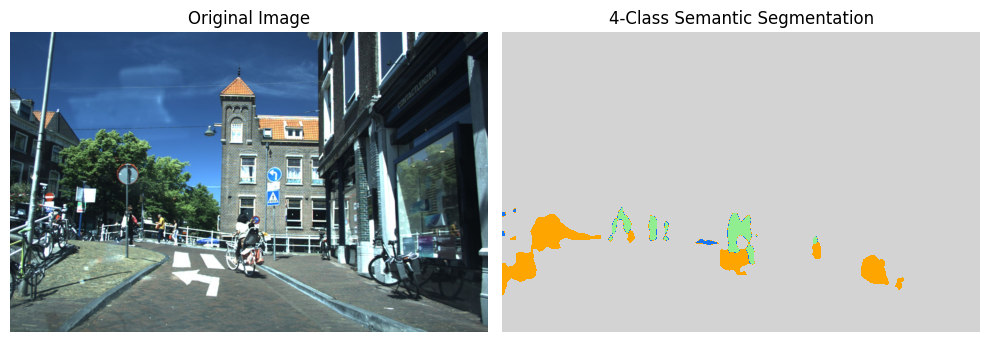

In [17]:
# # --- Visualize segmentation prediction (argmax of 4 classes) ---
pred_4class = np.argmax(output_reassign_softmax, axis=2)  # [H, W]
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(rgb)
# plt.title("Original Image")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(pred_4class, cmap='nipy_spectral')
# plt.title("4-Class Semantic Segmentation")
# plt.axis("off")
# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define custom colormap for the 4 semantic classes:
# 0: Background → Light Gray
# 1: Car        → Orange
# 2: Pedestrian → Light Blue
# 3: Bicycle    → Light Green
custom_cmap = ListedColormap([
    '#d3d3d3',  # Background - light gray
    '#ffa500',  # Car        - orange
    '#1976f3',  # Pedestrian - light blue
    '#90ee90',  # Bicycle    - light green
])

# Visualize original image and segmentation mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_4class, cmap=custom_cmap, vmin=0, vmax=3)
plt.title("4-Class Semantic Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()
